In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import time
import pickle

from warnings import filterwarnings
filterwarnings('ignore')

# (a) Load data

In [2]:
def load_data(fname):
    headline, topic = [], []
    with open(fname, 'r') as fin:
        for line in fin:
            items = line.strip().split("\t")
            headline.append(items[1])
            topic.append(items[0])
    print("Reading {} examples from: {}".format(len(headline), fname))
    return headline, topic

## i.

In [3]:
# Load data
trn_headline, trn_topic = load_data("news/news-trn.tsv")
val_headline, val_topic = load_data("news/news-val.tsv")
tst_headline, tst_topic = load_data("news/news-tst.tsv")

Reading 337810 examples from: news/news-trn.tsv
Reading 42155 examples from: news/news-val.tsv
Reading 42454 examples from: news/news-tst.tsv


## ii.

In [4]:
topics = np.unique(trn_topic, return_counts=True)

In [6]:
pd.DataFrame(topics[1], index=topics[0], columns=['# headlines'])

,# headlines
business,92786
entertainment,121815
health,36506
science_and_tech,86703


# (b) Consuct bag-of-words representations

In [50]:
vectorizer = CountVectorizer()
trn_data = vectorizer.fit_transform(trn_headline)
val_data = vectorizer.transform(val_headline)
tst_data = vectorizer.transform(tst_headline)

## i.

In [51]:
# Basic information about data
vocab = vectorizer.vocabulary_
print("Vocab size = {}".format(len(vocab)))
print("Size of training data = {}".format(trn_data.shape))
print("Size of val data = {}".format(val_data.shape))
print("Size of test data = {}".format(tst_data.shape))

Vocab size = 49028
Size of training data = (337810, 49028)
Size of val data = (42155, 49028)
Size of test data = (42454, 49028)


## ii.

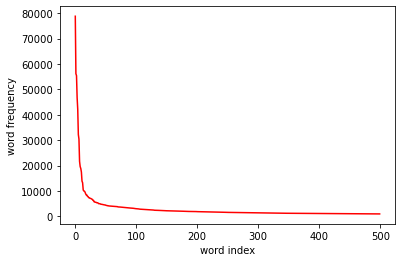

In [52]:
word_counts = trn_data.sum(axis=0).tolist()[0]
sorted_word_counts = [i for i in sorted(enumerate(word_counts), key=lambda x:x[1], reverse=True)]
ivocab = {val:key for (key, val) in vocab.items()}
plt.plot(range(len(ivocab))[:500], [v[1] for v in sorted_word_counts][:500], color="red") # Only the top 500 words
plt.xlabel("word index");
plt.ylabel("word frequency");

In [53]:
# Top 10 most used words
ordered_vocab = sorted(vocab.items())
indexes = [x[0] for x in sorted_word_counts[:10]]
list(ordered_vocab[i] for i in indexes)

[('to', 44089),
 ('the', 43619),
 ('in', 22657),
 ('of', 30974),
 ('for', 18048),
 ('on', 31171),
 ('and', 4034),
 ('with', 48051),
 ('new', 30079),
 ('at', 4991)]

# (c) Build a Classifier

In [54]:
classifier = LogisticRegression(fit_intercept=True, penalty="l2", C=1, max_iter=200)
classifier.fit(trn_data, trn_topic)

LogisticRegression(C=1, max_iter=200)

In [55]:
# Measure the performance on training and dev data
print("Training accuracy = {}".format(classifier.score(trn_data, trn_topic)))
print("Val accuracy = {}".format(classifier.score(val_data, val_topic)))

Training accuracy = 0.9691660992865813
Val accuracy = 0.9480488672755307


# (d) Hyper-parameter Tuning

### Don't execute the following cell, the processed data is loaded in the next cell

In [69]:
# Don't execute this cell, the processed data is loaded in the next cell

results = dict()
total_time_start = time.time()
for min_df in [1,5]:
    for max_df in [0.8, 1.0]:
        
        vectorizer = CountVectorizer(min_df=min_df, max_df=max_df)
        trn_data = vectorizer.fit_transform(trn_headline)
        val_data = vectorizer.transform(val_headline)

        for fit_intercept in [True, False]:
            for C in [10.0,1.0,0.1,0.001]:
                classifier_name = 'min_df='+str(min_df)+';max_df='+str(max_df)+';fit_intercept='+str(fit_intercept)+';C='+str(C)
                results[classifier_name] = dict()
                print(classifier_name, end = ' ')

                time_start = time.time()
                classifier = LogisticRegression(fit_intercept=fit_intercept, penalty="l2", C=C)
                classifier.fit(trn_data, trn_topic)
                time_end = time.time()
                duration = time_end - time_start

                print("Duration: "+str(duration))

                trn_acc = classifier.score(trn_data, trn_topic)
                val_acc = classifier.score(val_data, val_topic)   
                print('\t Training accuracy = {}'.format(trn_acc))
                print('\t Validation accuracy = {} \n'.format(val_acc))

                results[classifier_name]['trn acc'] = trn_acc
                results[classifier_name]['val acc'] = val_acc

total_time_end = time.time()
total_duration = total_time_end - total_time_start
print("Total duration = "+str(total_duration))

pickle.dump(results, open('results.pkl', 'wb'))

min_df=1;max_df=0.8;fit_intercept=True;C=10.0 Duration: 29.270467281341553
	 Training accuracy = 0.9688523134306267
	 Validation accuracy = 0.9448938441466018 

min_df=1;max_df=0.8;fit_intercept=True;C=1.0 Duration: 28.91478419303894
	 Training accuracy = 0.9649507119386638
	 Validation accuracy = 0.9468153243980548 

min_df=1;max_df=0.8;fit_intercept=True;C=0.1 Duration: 29.165798902511597
	 Training accuracy = 0.9487552174299162
	 Validation accuracy = 0.939081959435417 

min_df=1;max_df=0.8;fit_intercept=True;C=0.001 Duration: 12.031181335449219
	 Training accuracy = 0.8088304076255883
	 Validation accuracy = 0.8076384770489858 

min_df=1;max_df=0.8;fit_intercept=False;C=10.0 Duration: 26.351170301437378
	 Training accuracy = 0.9758148071401084
	 Validation accuracy = 0.9449412881034278 

min_df=1;max_df=0.8;fit_intercept=False;C=1.0 Duration: 26.504701375961304
	 Training accuracy = 0.9685977324531542
	 Validation accuracy = 0.9478828134266398 

min_df=1;max_df=0.8;fit_intercept=Fa

### Load results.pkl

In [70]:
results = pickle.load(open("results.pkl", "rb"))

In [101]:
# Get the best model from results

keys = list(results.keys())
best_model = 0
for i in range(len(results)):
    if results[keys[i]]['val acc'] > results[keys[best_model]]['val acc']:
        best_model = i

print('Best parameters: '+keys[best_model]+'\n')
print('Training accuracy = {}'.format(results[keys[best_model]]['trn acc']))
print('Validation accuracy = {} \n'.format(results[keys[best_model]]['val acc']))

Best parameters: min_df=1;max_df=0.8;fit_intercept=False;C=1.0

Training accuracy = 0.9685977324531542
Validation accuracy = 0.9478828134266398 



## Conclusion
The best model is the one that has the following parameters:
- C = 1.0
- min_df = 1
- max_df = 0.8
- fit_intercept = False

I choose this model according to the best validation accuracy obtained from all the trained models.

# (e) Find the Best Performance

## Train the best model

In [103]:
vectorizer = CountVectorizer(min_df=1, max_df=0.8)
trn_data = vectorizer.fit_transform(trn_headline)
val_data = vectorizer.transform(val_headline)
tst_data = vectorizer.transform(tst_headline)

In [104]:
classifier = LogisticRegression(fit_intercept=False, penalty="l2", C=1.0)
classifier.fit(trn_data, trn_topic)

LogisticRegression(fit_intercept=False)

In [116]:
prediction = classifier.predict(tst_data)

In [118]:
print(classification_report(tst_topic, prediction))

                  precision    recall  f1-score   support

        business       0.92      0.93      0.93     11575
   entertainment       0.97      0.98      0.98     15454
          health       0.95      0.93      0.94      4596
science_and_tech       0.93      0.93      0.93     10829

        accuracy                           0.95     42454
       macro avg       0.94      0.94      0.94     42454
    weighted avg       0.95      0.95      0.95     42454



## Create prediction file

In [120]:
f = open('./news-tst.pred','w')
for i, headline in enumerate(tst_headline):
    f.write(prediction[i] + '\t' + headline + '\n')
f.close()